# Statistical modelling
## TASK 7
## Importing data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

plt.style.use("seaborn-v0_8")

df = pd.read_csv("train_253253.csv", parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)
df = df.set_index("timestamp")
df = df.asfreq("h") 


try:
    df.index = df.index.tz_convert(None)  #removing timezone
except:
    df.index = df.index.tz_localize(None)  #removing native datetime
    

df = df.resample("h").asfreq()  # Resample to hourly frequency (fix irregular timestamps)

df["Demand"] = df["Demand"].interpolate() # Interpolate Demand only

# Optional: fill other numeric columns
for col in df.columns:
    if col != "Demand":
        df[col] = df[col].interpolate()

y = df["Demand"]
y.head()



timestamp
2013-07-01 00:00:00    0.27
2013-07-01 01:00:00    0.23
2013-07-01 02:00:00    0.26
2013-07-01 03:00:00    0.28
2013-07-01 04:00:00    0.29
Freq: h, Name: Demand, dtype: float64

ADF Statistic: -11.773439
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


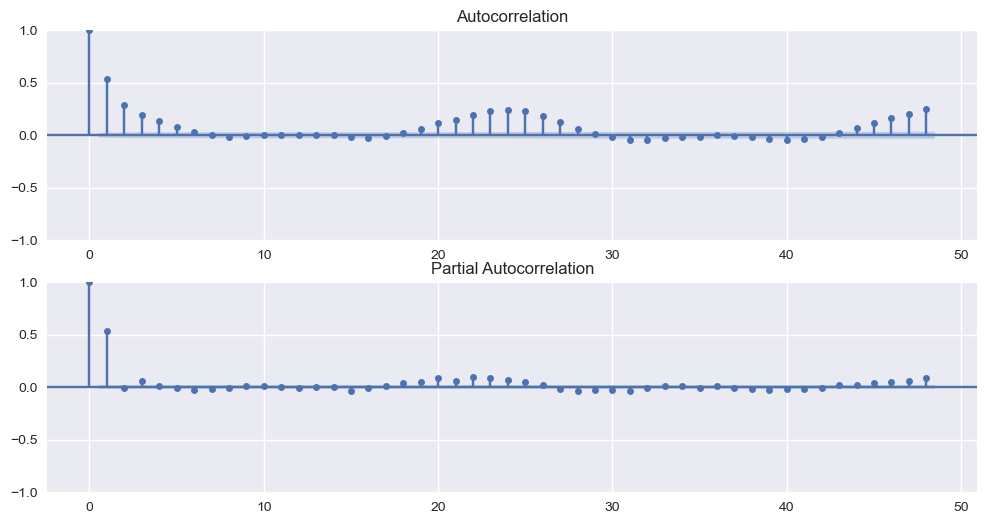

In [3]:
#cheking stationarity of original data
fuller_y = adfuller(y)
print('ADF Statistic: %f' % fuller_y[0])
print('p-value: %f' % fuller_y[1])
print('Critical Values:')
for key, value in fuller_y[4].items():
    print('\t%s: %.3f' % (key, value))

#ACF, PACF plots
fig, ax = plt.subplots(2,1, figsize=(12,6))
plot_acf(y, lags=48, ax=ax[0])
plot_pacf(y, lags=48, ax=ax[1])
plt.show()


## Task 7.1

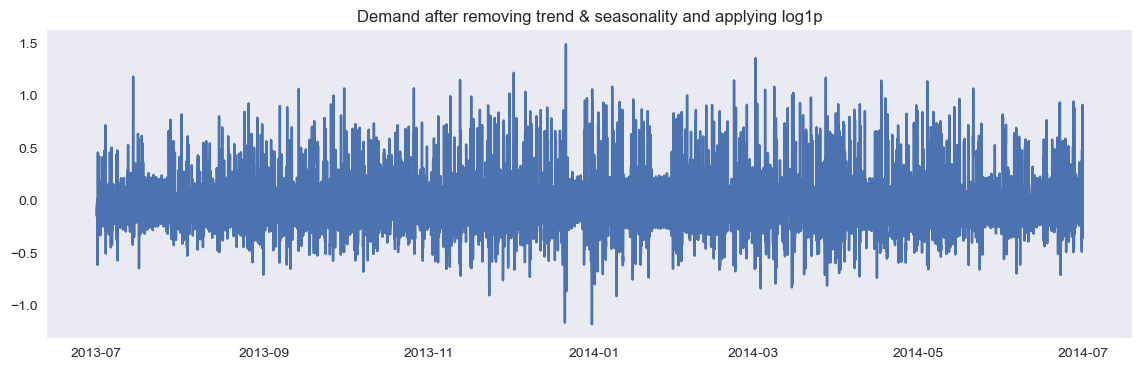

ADF p-value: 1.0893997629595528e-28


In [4]:
#making stationarity by decomposition
dec = seasonal_decompose(df["Demand"], model="additive", period=24, extrapolate_trend='freq')
trend = dec.trend
seasonal = dec.seasonal
resid = dec.resid

#adding log for stationarity
y_stat =dec.resid.dropna()
y_stat = np.log1p(y_stat)

plt.figure(figsize=(14,4))
plt.plot(y_stat)
plt.title("Demand after removing trend & seasonality and applying log1p")
plt.grid()
plt.show()

print("ADF p-value:", adfuller(y_stat)[1])


## Task 7.2

ADF Statistic: -15.795525
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
mean value:
-0.0369543350561496


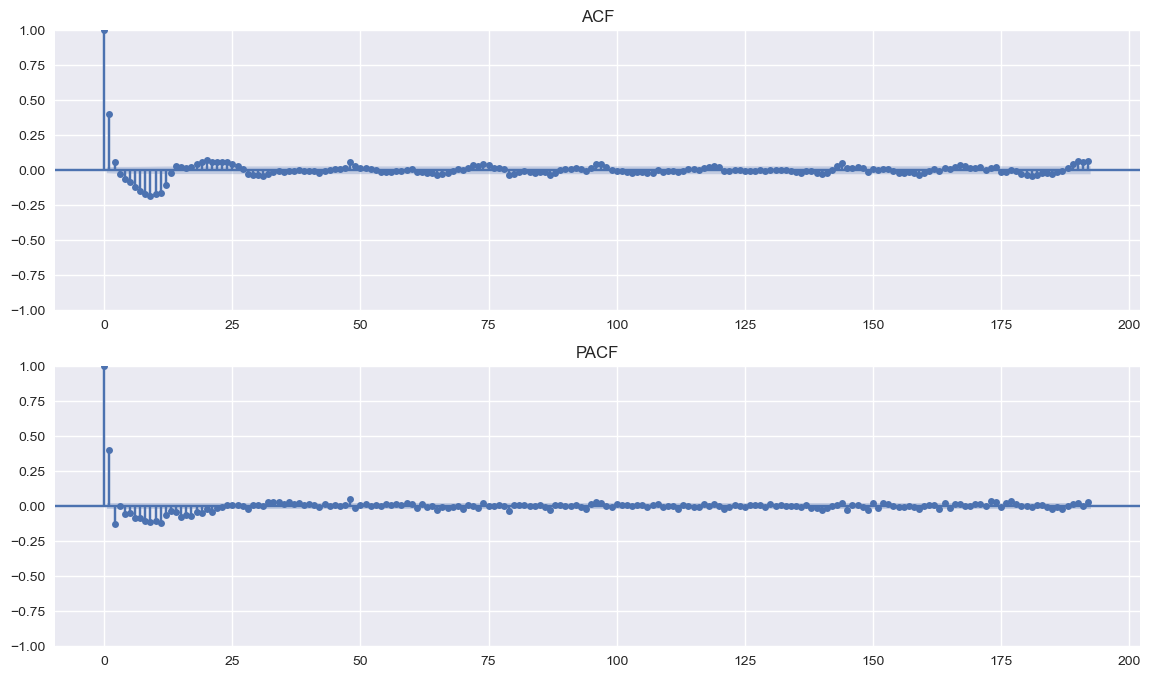

In [5]:
#cheking stationarity of decompose data
fuller_y_stat = adfuller(y_stat)
print('ADF Statistic: %f' % fuller_y_stat[0])
print('p-value: %f' % fuller_y_stat[1])
print('Critical Values:')
for key, value in fuller_y_stat[4].items():
    print('\t%s: %.3f' % (key, value))

print('mean value:')
print(y_stat.mean())
fig, ax = plt.subplots(2,1, figsize=(14,8))
plot_acf(y_stat, lags=192, ax=ax[0])
plot_pacf(y_stat, lags=192, ax=ax[1])
ax[0].set_title("ACF") # MA =2
ax[1].set_title("PACF") # AR = 1
plt.show()

## for Taks 7.4

In [6]:
#making nRMSE cheing with average and max-min values.

def nrmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / (np.max(y_true)-np.min(y_true))

def nrmse_mean(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / np.mean(y_true)

## Task 7.3, 7.4, 7.5

In [7]:
# making train and test time periods
train_data = y.loc[:"2014-06-22"]
test_data = y.loc["2014-06-23":"2014-06-30"]
train_data_stat = y_stat.loc[:"2014-06-22"]
test_data_stat = y_stat.loc["2014-06-23":"2014-06-30"]

In [14]:
#cheacking auto_ARIMA
import pmdarima as pm
auto_arima_stat = pm.auto_arima(y_stat, stepwise=False, seasonal=False)
auto_arima_stat

ARIMA(order=(4, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [39]:
#Making ARIME models
model1_stat = ARIMA(y_stat, order=(1,0,2)).fit()
model2_stat = ARIMA(y_stat, order=(4,0,1)).fit()

pred1_stat = model1_stat.predict(start=y_stat.index[1], end=y_stat.index[-1])
pred2_stat = model2_stat.predict(start=y_stat.index[1], end=y_stat.index[-1])

print("ARIMA(1,0,2) nRMSE:", nrmse(y_stat[1:], pred1_stat))
print("ARIMA(4,0,1) nRMSE:", nrmse(y_stat[1:], pred2_stat))

ARIMA(1,0,2) nRMSE: 0.08709169019216743
ARIMA(4,0,1) nRMSE: 0.08536411591328895


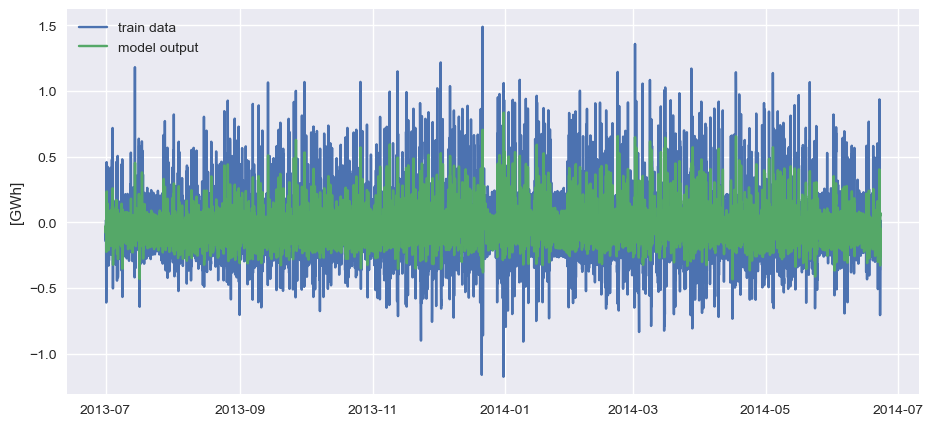

In [25]:
#chart on decomp data residuals.log
pred_start_date_stat = train_data_stat.index[0]
pred_end_date_stat = train_data_stat.index[-1]

validations_stat = model2_stat.predict(start=pred_start_date_stat, end=pred_end_date_stat)

plt.figure(figsize=(11,5))
plt.plot(train_data_stat, label="train data")
plt.plot(validations_stat, label="model output")
plt.ylabel('[GWh]')
plt.legend(loc="upper left")
plt.show()

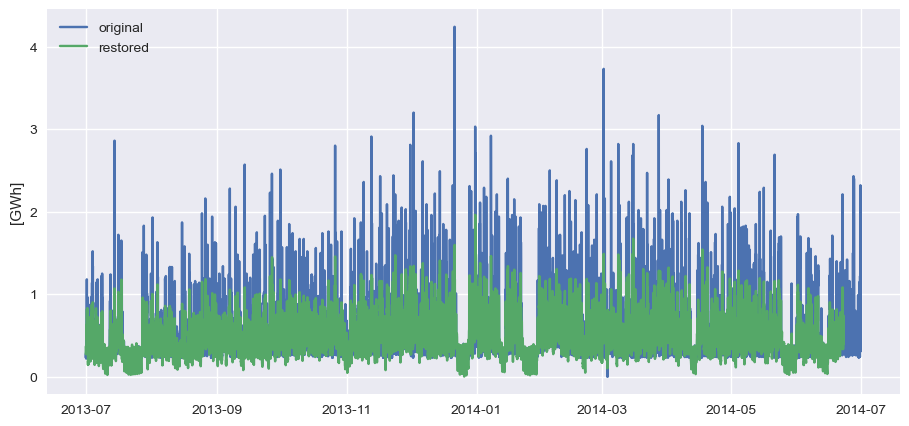

In [26]:
#adding seasonal and trend data to models
plt.figure(figsize=(11,5))
plt.plot(y, label="original")
plt.plot(validations_stat + trend + seasonal, label="restored")
plt.ylabel('[GWh]')
plt.legend(loc="upper left")
plt.show()

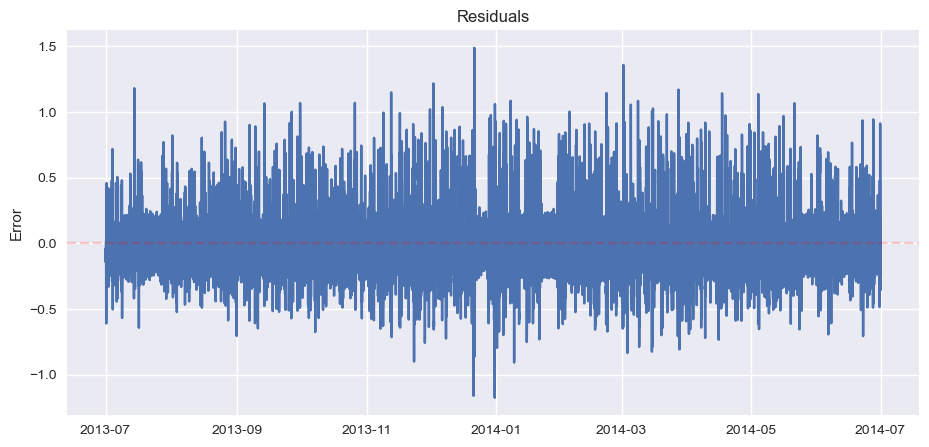

In [27]:
#checking residuals
fig_res = plt.figure(figsize=(11,5))
plt.plot(y_stat)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
plt.title('Residuals')
plt.ylabel('Error')
plt.show()

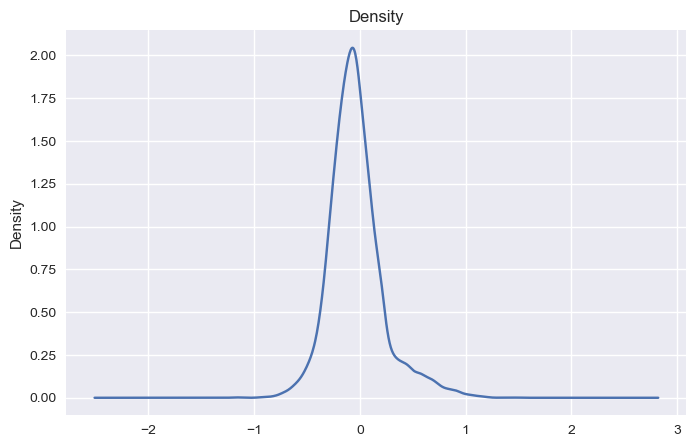

In [28]:
#cheacking normalised distrubution
fig_dens_res = plt.figure(figsize=(8,5))
y_stat.plot(title='Density', kind='kde')
plt.show()

In [29]:
#cheacking models over last week
last_week_size=7*24
y_full=y.copy()
errors1=[]
errors2=[]
start_idx=len(y_full)-last_week_size

for day in range(7):
    train_end=start_idx+day*24
    y_train=y_full.iloc[:train_end]
    y_test=y_full.iloc[train_end:train_end+24]

    if len(y_test)<24:
        continue
        
    f1=model1_stat.forecast(24)
    f2=model2_stat.forecast(24)

    errors1.append(nrmse(y_test.values, f1.values))
    errors2.append(nrmse(y_test.values, f2.values))

print("Daily nRMSE ARIMA(1,0,2):", errors1)
print("Daily nRMSE ARIMA(4,0,1):", errors2)
mean_errors = [np.mean(errors1), np.mean(errors2)]
print("Average nRMSE of ARIMA models:", mean_errors)


Daily nRMSE ARIMA(1,0,2): [0.5567630008760709, 0.6023740583937196, 0.7589255529202312, 0.47150376392588345, 0.8529973409301049, 0.6538393007148439, 0.3755996983309646]
Daily nRMSE ARIMA(4,0,1): [0.5555392757642218, 0.6028277737061863, 0.7563426822778361, 0.4698900641247304, 0.8532546334782131, 0.6551034508716465, 0.3751455073509193]
Average nRMSE of ARIMA models: [0.6102861022988312, 0.6097290553676791]


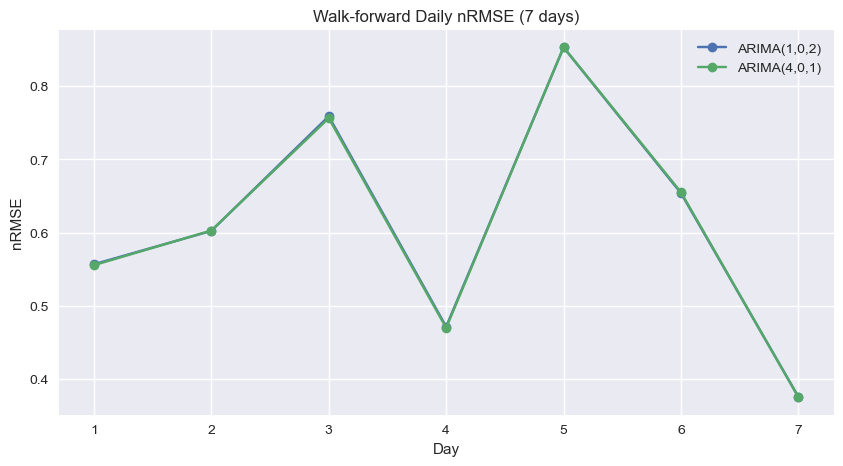

In [30]:
#graph for models comparing
plt.figure(figsize=(10,5))
plt.plot(data = test_data, label="PV")
plt.plot(range(1,len(errors1)+1), errors1, marker='o', label='ARIMA(1,0,2)')
plt.plot(range(1,len(errors2)+1), errors2, marker='o', label='ARIMA(4,0,1)')
plt.title("Walk-forward Daily nRMSE (7 days)")
plt.xlabel("Day")
plt.ylabel("nRMSE")
plt.xticks(range(1,len(errors1)+1))
plt.grid(True)
plt.legend()
plt.show()


### Information for Task 8 

MAPE: 111.243 MAE: 0.630 RMSE: 0.784


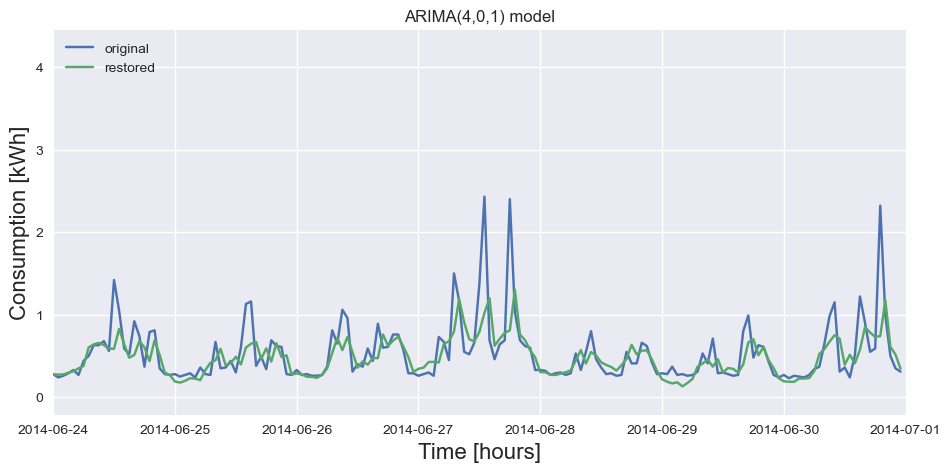

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

start_for_task8, end_for_task8 = "2014-06-24", "2014-07-01"
f2_for_task8=model2_stat.predict(start=start_for_task8, end=end_for_task8)
mapestring="MAPE: %.3f" % (mean_absolute_percentage_error(y_test.values, f2.values)*100)
maestring="MAE: %.3f" % (mean_absolute_error(y_test.values, f2.values))
rmsestring = "RMSE: %.3f" % (np.sqrt(mean_squared_error(y_test.values, f2.values)))
print(mapestring+" "+maestring+" "+rmsestring)

#print("ARIMA(4,0,1) RMSE:", np.sqrt(mean_squared_error(y_test.values, f2.values)))

plt.figure(figsize=(11,5))
plt.plot(y, label="original")
plt.plot(f2_for_task8 + trend + seasonal, label="restored")
plt.title("ARIMA(4,0,1) model")
plt.xlabel("Time [hours]", fontsize = 16);
plt.ylabel("Consumption [kWh]", fontsize = 16);
plt.xlim(pd.to_datetime(start_for_task8), pd.to_datetime(end_for_task8))
plt.legend(loc="upper left")
plt.show()

# Machine learning
## Task 8